In [1]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:

base_dir = "/kaggle/input/cell-images-for-detecting-malaria/cell_images"
file_lst = os.listdir(base_dir)


In [3]:
# Function to check if a file is an image
def is_image_file(file_path):
    # Get the file extension
    _, file_extension = os.path.splitext(file_path)
    # List of common image file extensions
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif', '.tif']
    return file_extension.lower() in image_extensions

In [4]:
# Load and filter the dataset
image_paths = []
labels = []

# Loop through the subdirectories (Uninfected and Parasitized)
for label in ['Uninfected', 'Parasitized']:
    folder_path = os.path.join(base_dir, label)
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        
        # Check if the file is an image
        if is_image_file(image_path):
            image_paths.append(image_path)
            labels.append(label)
        else:
            print(f"Skipping non-image file: {image_path}")

# Create a DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})
df.head()

Skipping non-image file: /kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/Thumbs.db
Skipping non-image file: /kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/Thumbs.db


,image_path,label
0,/kaggle/input/cell-images-for-detecting-malari...,Uninfected
1,/kaggle/input/cell-images-for-detecting-malari...,Uninfected
2,/kaggle/input/cell-images-for-detecting-malari...,Uninfected
3,/kaggle/input/cell-images-for-detecting-malari...,Uninfected
4,/kaggle/input/cell-images-for-detecting-malari...,Uninfected


In [5]:
# Check the distribution of labels
print(df['label'].value_counts())

label
Uninfected     13779
Parasitized    13779
Name: count, dtype: int64


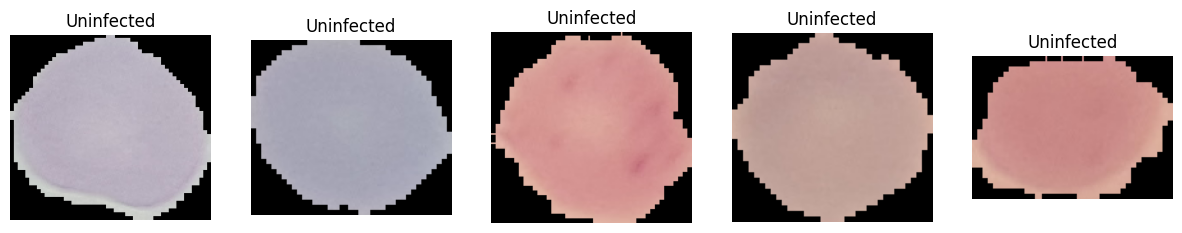

In [6]:
# Function to display images
def display_images(image_paths, labels, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        image = cv2.imread(image_paths[i])  # Load the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.imshow(image)
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

# Display a few images
display_images(df['image_path'].values, df['label'].values, num_images=5)

In [7]:
# Function to check if a file is an image
def is_image_file(file_path):
    # Get the file extension
    _, file_extension = os.path.splitext(file_path)
    # List of common image file extensions
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif', '.tif']
    return file_extension.lower() in image_extensions

In [8]:
# Function to preprocess images
def preprocess_image(image_path, target_size=(64, 64)):
    image = cv2.imread(image_path)  # Load the image
    
    # Check if the image is loaded properly
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return None  # Return None if the image cannot be loaded
    
    image = cv2.resize(image, target_size)  # Resize to target size
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

# Preprocess all images
images = []
valid_image_paths = []
for path in df['image_path']:
    processed_image = preprocess_image(path)
    if processed_image is not None:  # Skip invalid images
        images.append(processed_image)
        valid_image_paths.append(path)

# Filter the DataFrame to include only valid images
df = df[df['image_path'].isin(valid_image_paths)].reset_index(drop=True)

# Convert images to a NumPy array
images = np.array(images)

# One-hot encode the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['label'])
labels = to_categorical(labels, num_classes=2)  # 2 classes: Uninfected and Parasitized

In [9]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Split the training set further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Display the shapes of the datasets
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (17636, 64, 64, 3), (17636, 2)
Validation data shape: (4410, 64, 64, 3), (4410, 2)
Testing data shape: (5512, 64, 64, 3), (5512, 2)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build a baseline CNN model
def build_baseline_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),  # Adjust input shape to (64, 64, 3)
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')  # 2 classes: Uninfected and Parasitized
    ])
    return model

# Compile the model
baseline_cnn_model = build_baseline_cnn()
baseline_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
baseline_cnn_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,454,082 (9.36 MB)

 Trainable params: 2,454,082 (9.36 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Build a fine-tuned VGG16 model
def build_vgg16():
    # Load the pre-trained VGG16 model (without the top layers)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))  # Adjust input shape to (64, 64, 3)
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)  # 2 classes: Uninfected and Parasitized
    
    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Compile the model
vgg16_model = build_vgg16()
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
vgg16_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,370 (57.14 MB)

 Trainable params: 263,682 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
# Train the baseline CNN model
history_baseline_cnn = baseline_cnn_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/10


I0000 00:00:1734089851.839208     528 service.cc:145] XLA service 0x7a5108007570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734089851.839255     528 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734089851.839259     528 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 32/552 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5700 - loss: 0.7093

I0000 00:00:1734089856.065830     528 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


552/552 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7271 - loss: 0.5048 - val_accuracy: 0.9549 - val_loss: 0.1504
Epoch 2/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9491 - loss: 0.1537 - val_accuracy: 0.9549 - val_loss: 0.1469
Epoch 3/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9545 - loss: 0.1367 - val_accuracy: 0.9560 - val_loss: 0.1425
Epoch 4/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9580 - loss: 0.1185 - val_accuracy: 0.9608 - val_loss: 0.1242
Epoch 5/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9558 - loss: 0.1155 - val_accuracy: 0.9608 - val_loss: 0.1364
Epoch 6/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9615 - loss: 0.1076 - val_accuracy: 0.9590 - val_loss: 0.1262
Epoch 7/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9670 - loss: 0.0926 - val_accuracy: 0.9578 - val_loss: 0.1370
Epoch 8/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9698 - loss: 0.0827 - val_accuracy: 0.9553 - va

In [14]:
# Train the fine-tuned ResNet50 model
history_vgg16 = vgg16_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.8281 - loss: 0.3641 - val_accuracy: 0.9200 - val_loss: 0.2110
Epoch 2/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9149 - loss: 0.2211 - val_accuracy: 0.9222 - val_loss: 0.2036
Epoch 3/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9197 - loss: 0.2034 - val_accuracy: 0.9179 - val_loss: 0.1979
Epoch 4/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9310 - loss: 0.1841 - val_accuracy: 0.9306 - val_loss: 0.1856
Epoch 5/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9313 - loss: 0.1759 - val_accuracy: 0.9354 - val_loss: 0.1773
Epoch 6/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9311 - loss: 0.1758 - val_accuracy: 0.9143 - val_loss: 0.2036
Epoch 7/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9335 - loss: 0.1698 - val_accuracy: 0.9177 - val_loss: 0.2118
Epoch 8/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9364 - loss: 0.1592 - 

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict on the test set
y_pred_baseline_cnn = baseline_cnn_model.predict(X_test)
y_pred_baseline_cnn = np.argmax(y_pred_baseline_cnn, axis=1)  # Convert one-hot to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot to class labels

# Calculate metrics
accuracy_baseline_cnn = accuracy_score(y_true, y_pred_baseline_cnn)
precision_baseline_cnn = precision_score(y_true, y_pred_baseline_cnn)
recall_baseline_cnn = recall_score(y_true, y_pred_baseline_cnn)
f1_baseline_cnn = f1_score(y_true, y_pred_baseline_cnn)

# Print metrics
print("Baseline CNN Metrics:")
print(f"Accuracy: {accuracy_baseline_cnn:.4f}")
print(f"Precision: {precision_baseline_cnn:.4f}")
print(f"Recall: {recall_baseline_cnn:.4f}")
print(f"F1-Score: {f1_baseline_cnn:.4f}")

# Confusion Matrix
conf_matrix_baseline_cnn = confusion_matrix(y_true, y_pred_baseline_cnn)
print("Confusion Matrix:")
print(conf_matrix_baseline_cnn)

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Baseline CNN Metrics:
Accuracy: 0.9581
Precision: 0.9486
Recall: 0.9700
F1-Score: 0.9592
Confusion Matrix:
[[2568  147]
 [  84 2713]]


In [19]:
# Predict on the test set
y_pred_vgg16 = vgg16_model .predict(X_test)
y_pred_vgg16 = np.argmax(y_pred_vgg16, axis=1)  # Convert one-hot to class labels

# Calculate metrics
accuracy_vgg16 = accuracy_score(y_true, y_pred_vgg16)
precision_vgg16 = precision_score(y_true, y_pred_vgg16)
recall_vgg16 = recall_score(y_true, y_pred_vgg16)
f1_vgg16 = f1_score(y_true, y_pred_vgg16)

# Print metrics
print("Fine-Tuned ResNet50 Metrics:")
print(f"Accuracy: {accuracy_vgg16:.4f}")
print(f"Precision: {precision_vgg16:.4f}")
print(f"Recall: {recall_vgg16:.4f}")
print(f"F1-Score: {f1_vgg16:.4f}")

# Confusion Matrix
conf_matrix_vgg16 = confusion_matrix(y_true, y_pred_vgg16)
print("Confusion Matrix:")
print(conf_matrix_vgg16)

173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Fine-Tuned ResNet50 Metrics:
Accuracy: 0.9254
Precision: 0.9412
Recall: 0.9099
F1-Score: 0.9253
Confusion Matrix:
[[2556  159]
 [ 252 2545]]


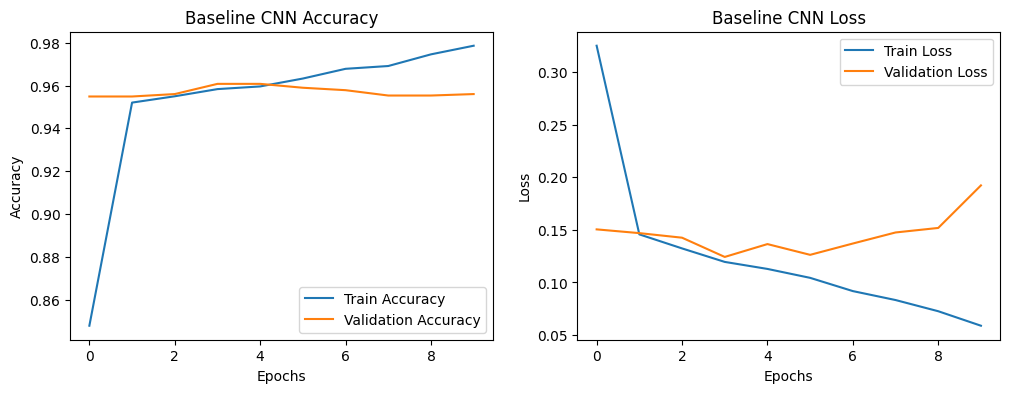

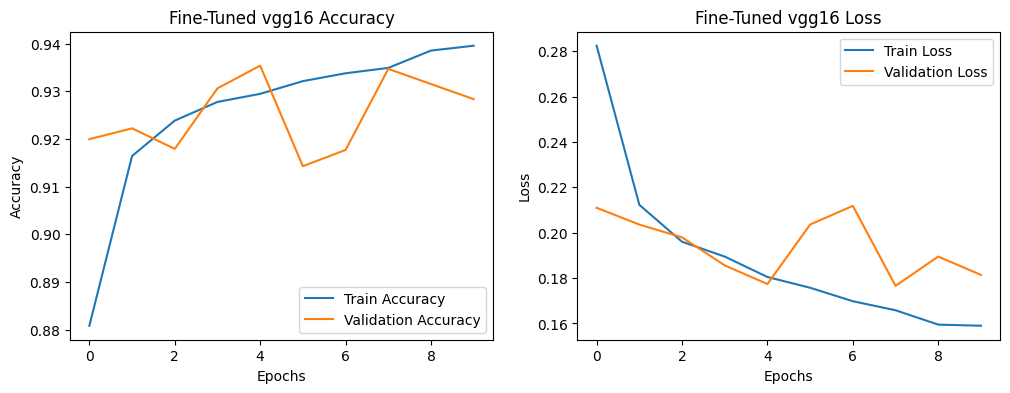

In [21]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Plot results for baseline CNN
plot_history(history_baseline_cnn, "Baseline CNN")

# Plot results for ResNet50
plot_history(history_vgg16, "Fine-Tuned vgg16")